In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import glob, os
import DeepLabModel
import seaborn as sb

In [2]:
DATASET_PATH = '../../datasets/VOCdevkit/VOC2012/'
PNG_PATH = DATASET_PATH + 'JPEGImages/'
SEG_PATH = DATASET_PATH + 'SegmentationClass/'
SRC_LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
SRC_LABELS_NOBG = [l for l in SRC_LABEL_NAMES if l not in ['background']]

Pairing PNG and SEG

In [3]:
paired = [(PNG_PATH+os.path.basename(filename.replace('.png', '.jpg')), SEG_PATH+os.path.basename(filename)) for filename in glob.glob(SEG_PATH+'*.png')]

In [4]:
# Checking that all files exist
all([os.path.isfile(v[0]) for v in paired])

True

Checking the labels contained in each image

In [10]:

src_dataset = pd.DataFrame(columns=['png', 'seg']+ SRC_LABELS_NOBG)
for i, (png, seg) in enumerate(paired):
    new_row = {'png':png, 'seg':seg}
    new_row.update({labn: False for labn in SRC_LABELS_NOBG})
    seg_im = Image.open(seg).convert('P')
    found_labels = np.unique(seg_im)
    # Removing label 255 "difficult" and 'background'
    found_labels = found_labels[~np.isin(found_labels, [0, 255])]
    for c in found_labels:
        # We removed label 0 so everything is shifted by one
        new_row[SRC_LABELS_NOBG[c-1]] = True
    src_dataset = src_dataset.append(new_row, ignore_index=True)  
    print("Done {} of {}".format(i, len(paired)))
src_dataset.to_csv('datasets/VOC2012_label_presence.csv')
    
    

Done 0 of 2913
Done 1 of 2913
Done 2 of 2913
Done 3 of 2913
Done 4 of 2913
Done 5 of 2913
Done 6 of 2913
Done 7 of 2913
Done 8 of 2913
Done 9 of 2913
Done 10 of 2913
Done 11 of 2913
Done 12 of 2913
Done 13 of 2913
Done 14 of 2913
Done 15 of 2913
Done 16 of 2913
Done 17 of 2913
Done 18 of 2913
Done 19 of 2913
Done 20 of 2913
Done 21 of 2913
Done 22 of 2913
Done 23 of 2913
Done 24 of 2913
Done 25 of 2913
Done 26 of 2913
Done 27 of 2913
Done 28 of 2913
Done 29 of 2913
Done 30 of 2913
Done 31 of 2913
Done 32 of 2913
Done 33 of 2913
Done 34 of 2913
Done 35 of 2913
Done 36 of 2913
Done 37 of 2913
Done 38 of 2913
Done 39 of 2913
Done 40 of 2913
Done 41 of 2913
Done 42 of 2913
Done 43 of 2913
Done 44 of 2913
Done 45 of 2913
Done 46 of 2913
Done 47 of 2913
Done 48 of 2913
Done 49 of 2913
Done 50 of 2913
Done 51 of 2913
Done 52 of 2913
Done 53 of 2913
Done 54 of 2913
Done 55 of 2913
Done 56 of 2913
Done 57 of 2913
Done 58 of 2913
Done 59 of 2913
Done 60 of 2913
Done 61 of 2913
Done 62 of 2913
Do

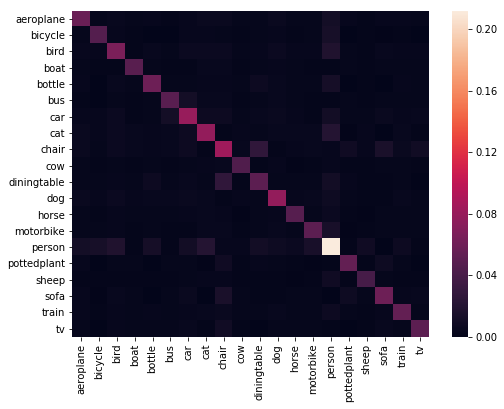

In [43]:
lab_count = src_dataset[SRC_LABELS_NOBG].astype(np.uint8)
lab_covariance = lab_count.cov()
lab_covariance.to_csv('datasets/VOC2012_label_covariance.csv')
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sb.heatmap(lab_covariance.abs())
plt.savefig('datasets/VOC2012_heatmap.png')

In [49]:
occurrences = lab_count.transpose().dot(lab_count)
candidates = set(occurrences[occurrences == 0].stack().index)

In [71]:
selected = ['dog', 'cat']
lab_count[selected].transpose().dot(lab_count[selected])


,dog,cat
dog,249,7
cat,7,250


In [123]:
lab_count.sum().nlargest()

person    888
chair     271
car       255
cat       250
dog       249
dtype: int64

In [118]:
sum(np.diag(lab_occurrence))

3294

In [132]:
# Candidates: Dog, Bird, Cat, Car
filtered = src_dataset[src_dataset['dog'] | src_dataset['cat'] | src_dataset['car'] | src_dataset['bird']]

In [134]:
filtered_count = filtered[['dog', 'cat', 'car', 'bird']].astype(np.uint8)
filtered_occurrence = filtered_count.transpose().dot(filtered_count)

In [136]:
filtered_occurrence

,dog,cat,car,bird
dog,249,7,6,0
cat,7,250,1,0
car,6,1,255,1
bird,0,0,1,208


In [73]:
SRC_LABEL_NAMES.index('cat')

8